
## misc


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install lightgbm

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA  # Import PCA
import lightgbm as lgb
import pickle
import json
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
print("done")

done


## data prep

In [ ]:
def load_and_prepare_data(file_path, max_rows=None):
    """Load parquet and prepare features (with optional row limit for testing)"""
    print("Loading data...")

    if max_rows is not None:
        df = pd.read_parquet(file_path).sample(n=max_rows, random_state=42).reset_index(drop=True)
        print(f"⚠️ Loaded only {len(df):,} samples for testing (max_rows={max_rows})")
    else:
        df = pd.read_parquet(file_path)
        print(f"✓ Loaded {len(df):,} samples")

    content_emb = np.stack(df['content_embedding'].values)
    user_company_emb = np.stack(df['user_company_embedding'].values)

    n_components_pca = 90
    pca = PCA(n_components=n_components_pca, random_state=42)
    user_company_emb_pca = pca.fit_transform(user_company_emb)
    print(f"✓ Applied PCA to user_company_embedding: reduced from {user_company_emb.shape[1]} to {user_company_emb_pca.shape[1]} components")


    time_features = df[['hour_sin', 'hour_cos', 'week_sin', 'week_cos',
                        'month_sin', 'month_cos']].values

    word_count = df[['word_count']].values

    X = np.hstack([time_features, word_count, content_emb, user_company_emb_pca])
    y = df['likes_log'].values

    print(f"✓ Feature matrix shape: {X.shape}")
    print(f"✓ Total features: {X.shape[1]} (6 time + 1 word_count + {content_emb.shape[1]} content emb + {user_company_emb_pca.shape[1]} user_company_emb_pca)")


    # Metadata for stratified splits
    metadata = {
        'companies': df['inferred company'].values,
        'usernames': df['username'].values,
        'ids': df['id'].values
    }

    return X, y, metadata


print("data loaded")

data loaded


In [ ]:
def create_evaluation_splits(X, y, metadata, test_size=0.15, val_size=0.15, random_state=42):
    """
    Create splits for two evaluation scenarios:
    1. Unseen brands (seen time)
    2. Unseen time (seen brands)
    """
    companies = metadata['companies']
    unique_companies = np.unique(companies)

    print(f"\n{'='*80}")
    print("CREATING EVALUATION SPLITS")
    print(f"{'='*80}")
    print(f"Total samples: {len(X):,}")
    print(f"Total companies: {len(unique_companies)}")

    # Split 1: Standard split (for general validation)
    X_temp, X_test_standard, y_temp, y_test_standard = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=None
    )
    X_train, X_val_standard, y_train, y_val_standard = train_test_split(
        X_temp, y_temp, test_size=val_size/(1-test_size), random_state=random_state
    )

    print(f"\n✓ Standard Split:")
    print(f"  Train: {len(X_train):>7,} samples")
    print(f"  Val:   {len(X_val_standard):>7,} samples")
    print(f"  Test:  {len(X_test_standard):>7,} samples")

    # Split 2: Unseen brands split
    np.random.seed(random_state)
    n_test_companies = int(len(unique_companies) * test_size)
    test_companies = np.random.choice(unique_companies, n_test_companies, replace=False)

    test_mask = np.isin(companies, test_companies)
    X_train_unseen_brands = X[~test_mask]
    y_train_unseen_brands = y[~test_mask]
    X_test_unseen_brands = X[test_mask]
    y_test_unseen_brands = y[test_mask]

    print(f"\n✓ Unseen Brands Split:")
    print(f"  Train: {len(X_train_unseen_brands):>7,} samples ({len(unique_companies) - n_test_companies} companies)")
    print(f"  Test:  {len(X_test_unseen_brands):>7,} samples ({n_test_companies} companies)")
    print(f"  Test companies: {test_companies[:5]}... (showing first 5)")

    return {
        'standard': {
            'X_train': X_train,
            'X_val': X_val_standard,
            'X_test': X_test_standard,
            'y_train': y_train,
            'y_val': y_val_standard,
            'y_test': y_test_standard
        },
        'unseen_brands': {
            'X_train': X_train_unseen_brands,
            'X_test': X_test_unseen_brands,
            'y_train': y_train_unseen_brands,
            'y_test': y_test_unseen_brands,
            'test_companies': test_companies
        }
    }

print("data split done")

data split done


## model prep

In [ ]:
class LGBMHybridModel:
    """
    Two-stage model:
    1. Classifier predicts engagement bin
    2. Regressor uses features + bin probabilities
    """

    def __init__(self, n_bins=5, use_quantile_bins=True, verbose=True):
        self.n_bins = n_bins
        self.use_quantile_bins = use_quantile_bins
        self.verbose = verbose
        self.bin_edges = None
        self.classifier = None
        self.regressor = None

    def _create_bins(self, y):
        """Create engagement bins"""
        if self.bin_edges is None:
            if self.use_quantile_bins:
                self.bin_edges = np.quantile(y, np.linspace(0, 1, self.n_bins + 1))
            else:
                self.bin_edges = np.linspace(y.min(), y.max(), self.n_bins + 1)

            self.bin_edges = np.unique(self.bin_edges)

            if self.verbose:
                print(f"\n✓ Created {len(self.bin_edges)-1} bins:")
                for i in range(len(self.bin_edges)-1):
                    print(f"  Bin {i}: [{self.bin_edges[i]:.2f}, {self.bin_edges[i+1]:.2f})")

        bins = np.digitize(y, self.bin_edges[1:-1])
        return bins

    def fit(self, X, y, X_val=None, y_val=None):
        """Train both classifier and regressor"""

        # Create bins
        y_bins = self._create_bins(y)

        if self.verbose:
            print(f"\n{'='*80}")
            print("TRAINING CLASSIFIER")
            print(f"{'='*80}")

        # Train classifier
        self.classifier = lgb.LGBMClassifier(
            objective='multiclass',
            num_class=self.n_bins,
            n_estimators=300,
            learning_rate=0.05,
            max_depth=8,
            num_leaves=31,
            feature_fraction=0.8,
            bagging_fraction=0.8,
            bagging_freq=5,
            min_child_samples=20,
            verbose=-1,
            device='gpu',  # Enable GPU training
            gpu_platform_id=0,
            gpu_device_id=0
        )

        if X_val is not None:
            y_val_bins = self._create_bins(y_val)
            eval_set = [(X_val, y_val_bins)]
            callbacks = [lgb.early_stopping(50, verbose=False)]
        else:
            eval_set = None
            callbacks = None

        self.classifier.fit(X, y_bins, eval_set=eval_set, callbacks=callbacks)

        # Get bin probabilities
        bin_probs_train = self.classifier.predict_proba(X)

        if self.verbose:
            train_acc = (self.classifier.predict(X) == y_bins).mean()
            print(f"✓ Classifier training accuracy: {train_acc:.4f}")
            if X_val is not None:
                val_acc = (self.classifier.predict(X_val) == y_val_bins).mean()
                print(f"✓ Classifier validation accuracy: {val_acc:.4f}")

        # Augment features with bin probabilities
        X_augmented = np.hstack([X, bin_probs_train])

        if self.verbose:
            print(f"\n{'='*80}")
            print("TRAINING REGRESSOR")
            print(f"{'='*80}")

        # Train regressor
        self.regressor = lgb.LGBMRegressor(
            objective='huber',
            alpha=0.9,
            n_estimators=500,
            learning_rate=0.03,
            max_depth=10,
            num_leaves=63,
            feature_fraction=0.8,
            bagging_fraction=0.8,
            bagging_freq=5,
            min_child_samples=20,
            verbose=-1,
            device='gpu',  # Enable GPU training
            gpu_platform_id=0,
            gpu_device_id=0
        )

        if X_val is not None:
            bin_probs_val = self.classifier.predict_proba(X_val)
            X_val_augmented = np.hstack([X_val, bin_probs_val])
            eval_set = [(X_val_augmented, y_val)]
            callbacks = [lgb.early_stopping(100, verbose=False)]
        else:
            eval_set = None
            callbacks = None

        self.regressor.fit(X_augmented, y, eval_set=eval_set, callbacks=callbacks)

        if self.verbose:
            y_pred_train = self.predict(X)
            train_rmse = np.sqrt(mean_squared_error(y, y_pred_train))
            train_mae = mean_absolute_error(y, y_pred_train)
            print(f"✓ Regressor training RMSE: {train_rmse:.4f}")
            print(f"✓ Regressor training MAE:  {train_mae:.4f}")

            if X_val is not None:
                y_pred_val = self.predict(X_val)
                val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
                val_mae = mean_absolute_error(y_val, y_pred_val)
                print(f"✓ Regressor validation RMSE: {val_rmse:.4f}")
                print(f"✓ Regressor validation MAE:  {val_mae:.4f}")

        return self

    def predict(self, X):
        """Predict likes_log"""
        bin_probs = self.classifier.predict_proba(X)
        X_augmented = np.hstack([X, bin_probs])
        return self.regressor.predict(X_augmented)

    def get_feature_importance(self, feature_names=None):
        """Get feature importance from regressor (excluding bin probabilities)"""
        importance = self.regressor.feature_importances_[:-self.n_bins]

        if feature_names is not None:
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importance
            }).sort_values('importance', ascending=False)
            return importance_df

        return importance

    def save_model(self, save_dir='/content/drive/MyDrive/AdobeBehaviourChal/saved_models', model_name=None):
        """
        Save model to disk

        Args:
            save_dir: Directory to save model
            model_name: Optional custom name, otherwise uses timestamp
        """
        # Create directory if doesn't exist
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

        # Generate model name with timestamp
        if model_name is None:
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            model_name = f'hybrid_model_{timestamp}'

        model_path = save_dir / model_name
        model_path.mkdir(parents=True, exist_ok=True)

        # Save classifier
        with open(model_path / 'classifier.pkl', 'wb') as f:
            pickle.dump(self.classifier, f)

        # Save regressor
        with open(model_path / 'regressor.pkl', 'wb') as f:
            pickle.dump(self.regressor, f)

        # Save metadata
        metadata = {
            'n_bins': self.n_bins,
            'use_quantile_bins': self.use_quantile_bins,
            'bin_edges': self.bin_edges.tolist() if self.bin_edges is not None else None,
            'saved_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        with open(model_path / 'metadata.json', 'w') as f:
            json.dump(metadata, f, indent=2)

        print(f"\n✓ Model saved to: {model_path}")
        print(f"  - classifier.pkl")
        print(f"  - regressor.pkl")
        print(f"  - metadata.json")

        return str(model_path)

    @classmethod
    def load_model(cls, model_path, verbose=True):
        """
        Load model from disk

        Args:
            model_path: Path to saved model directory
            verbose: Print loading info

        Returns:
            Loaded LGBMHybridModel instance
        """
        model_path = Path(model_path)

        if not model_path.exists():
            raise FileNotFoundError(f"Model path not found: {model_path}")

        # Load metadata
        with open(model_path / 'metadata.json', 'r') as f:
            metadata = json.load(f)

        # Create model instance
        model = cls(
            n_bins=metadata['n_bins'],
            use_quantile_bins=metadata['use_quantile_bins'],
            verbose=verbose
        )

        # Load classifier
        with open(model_path / 'classifier.pkl', 'rb') as f:
            model.classifier = pickle.load(f)

        # Load regressor
        with open(model_path / 'regressor.pkl', 'rb') as f:
            model.regressor = pickle.load(f)

        # Load bin edges
        if metadata['bin_edges'] is not None:
            model.bin_edges = np.array(metadata['bin_edges'])

        if verbose:
            print(f"\n✓ Model loaded from: {model_path}")
            print(f"  Saved at: {metadata['saved_at']}")
            print(f"  Bins: {metadata['n_bins']}")

        return model

print("model done")

model done


In [ ]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """Comprehensive evaluation"""
    # Calculate metrics on log scale
    mse_log = mean_squared_error(y_true, y_pred)
    rmse_log = np.sqrt(mse_log)
    mae_log = mean_absolute_error(y_true, y_pred)
    r2_log = r2_score(y_true, y_pred)

    # Calculate metrics on original scale
    # Apply inverse log transform: z = e^y - 1
    z_true = np.exp(y_true) - 1
    z_pred = np.exp(y_pred) - 1

    # Ensure non-negative predictions on original scale
    z_pred[z_pred < 0] = 0

    mse_original = mean_squared_error(z_true, z_pred)
    rmse_original = np.sqrt(mse_original)
    mae_original = mean_absolute_error(z_true, z_pred)
    # R2 on original scale might not be meaningful due to the transformation and non-negativity constraint

    # MAPE calculation (use original scale as it's more intuitive)
    mape_original = np.mean(np.abs((z_true - z_pred) / (z_true + 1e-8))) * 100  # +1e-8 to avoid div by 0


    print(f"\n{'='*80}")
    print(f"{model_name} PERFORMANCE")
    print(f"{'='*80}")
    print("Metrics on Log Scale (likes_log):")
    print(f"  RMSE:  {rmse_log:.4f}")
    print(f"  MAE:   {mae_log:.4f}")
    print(f"  R²:    {r2_log:.4f}")

    print("\nMetrics on Original Scale (likes):")
    print(f"  RMSE:  {rmse_original:.4f}")
    print(f"  MAE:   {mae_original:.4f}")
    print(f"  MAPE:  {mape_original:.2f}%")


    return {
        'rmse_log': rmse_log,
        'mae_log': mae_log,
        'r2_log': r2_log,
        'rmse_original': rmse_original,
        'mae_original': mae_original,
        'mape_original': mape_original
    }


def plot_predictions(y_true, y_pred, title="Predictions vs Actual"):
    """Visualize prediction quality"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Scatter plot (on log scale)
    sample_size = min(5000, len(y_true))
    sample_idx = np.random.choice(len(y_true), sample_size, replace=False)

    axes[0].scatter(y_true[sample_idx], y_pred[sample_idx], alpha=0.3, s=10)
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
                 'r--', lw=2, label='Perfect prediction')
    axes[0].set_xlabel('Actual likes_log')
    axes[0].set_ylabel('Predicted likes_log')
    axes[0].set_title(f'{title}\n(5k sample)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Residual plot (on log scale)
    residuals = y_true - y_pred
    axes[1].scatter(y_pred[sample_idx], residuals[sample_idx], alpha=0.3, s=10)
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1].set_xlabel('Predicted likes_log')
    axes[1].set_ylabel('Residuals')
    axes[1].set_title('Residual Plot (Log Scale)')
    axes[1].grid(True, alpha=0.3)

    # Distribution comparison (on log scale)
    axes[2].hist(y_true, bins=50, alpha=0.5, label='Actual', edgecolor='black')
    axes[2].hist(y_pred, bins=50, alpha=0.5, label='Predicted', edgecolor='black')
    axes[2].set_xlabel('likes_log')
    axes[2].set_ylabel('Frequency')
    axes[2].set_title('Distribution Comparison (Log Scale)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("evaulation done")

evaulation done


## main

In [ ]:
def main_pipeline(file_path, n_bins=5, test_on_unseen_brands=True, save_model=True, model_name=None):
    """Complete training and evaluation pipeline"""

    print(f"\n{'='*80}")
    print("HYBRID CLASSIFICATION-REGRESSION MODEL")
    print("TWEET LIKES PREDICTION")
    print(f"{'='*80}\n")

    # Load data
    X, y, metadata = load_and_prepare_data(file_path,50000)

    # Create splits
    splits = create_evaluation_splits(X, y, metadata)

    # ============================================
    # TRAIN ON STANDARD SPLIT
    # ============================================
    print(f"\n{'='*80}")
    print("TRAINING ON STANDARD SPLIT")
    print(f"{'='*80}")

    model = LGBMHybridModel(n_bins=n_bins, use_quantile_bins=True, verbose=True)
    model.fit(
        splits['standard']['X_train'],
        splits['standard']['y_train'],
        splits['standard']['X_val'],
        splits['standard']['y_val']
    )

    # Evaluate on standard test
    y_pred_test = model.predict(splits['standard']['X_test'])
    results_standard = evaluate_model(
        splits['standard']['y_test'],
        y_pred_test,
        "Standard Test Set"
    )

    plot_predictions(
        splits['standard']['y_test'],
        y_pred_test,
        "Standard Split: Predictions vs Actual"
    )

    # Save the standard model
    if save_model:
        saved_path = model.save_model(model_name=model_name or 'standard_split_model')

    # ============================================
    # TRAIN AND EVALUATE ON UNSEEN BRANDS
    # ============================================
    if test_on_unseen_brands:
        print(f"\n{'='*80}")
        print("TRAINING FOR UNSEEN BRANDS EVALUATION")
        print(f"{'='*80}")

        model_unseen = LGBMHybridModel(n_bins=n_bins, use_quantile_bins=True, verbose=True)
        model_unseen.fit(
            splits['unseen_brands']['X_train'],
            splits['unseen_brands']['y_train']
        )

        y_pred_unseen = model_unseen.predict(splits['unseen_brands']['X_test'])
        results_unseen = evaluate_model(
            splits['unseen_brands']['y_test'],
            y_pred_unseen,
            "Unseen Brands Test Set"
        )

        plot_predictions(
            splits['unseen_brands']['y_test'],
            y_pred_unseen,
            "Unseen Brands: Predictions vs Actual"
        )

        # Save the unseen brands model
        if save_model:
            saved_path_unseen = model_unseen.save_model(model_name='unseen_brands_model')

    # ============================================
    # SUMMARY
    # ============================================
    print(f"\n{'='*80}")
    print("FINAL SUMMARY")
    print(f"{'='*80}")
    print("\nStandard Split Results:")
    print(f"  RMSE: {results_standard['rmse']:.4f}")
    print(f"  MAE:  {results_standard['mae']:.4f}")
    print(f"  R²:   {results_standard['r2']:.4f}")

    if test_on_unseen_brands:
        print("\nUnseen Brands Results:")
        print(f"  RMSE: {results_unseen['rmse']:.4f}")
        print(f"  MAE:  {results_unseen['mae']:.4f}")
        print(f"  R²:   {results_unseen['r2']:.4f}")

        return model, model_unseen, results_standard, results_unseen

    return model, results_standard


HYBRID CLASSIFICATION-REGRESSION MODEL
TWEET LIKES PREDICTION

Loading data...
⚠️ Loaded only 50,000 samples for testing (max_rows=50000)
✓ Applied PCA to user_company_embedding: reduced from 768 to 90 components
✓ Feature matrix shape: (50000, 865)
✓ Total features: 865 (6 time + 1 word_count + 768 content emb + 90 user_company_emb_pca)

CREATING EVALUATION SPLITS
Total samples: 50,000
Total companies: 214

✓ Standard Split:
  Train:  34,999 samples
  Val:     7,501 samples
  Test:    7,500 samples

✓ Unseen Brands Split:
  Train:  43,497 samples (182 companies)
  Test:    6,503 samples (32 companies)
  Test companies: ['allstate' 'ups' 'free' 'twitter' 'midea']... (showing first 5)

TRAINING ON STANDARD SPLIT

✓ Created 5 bins:
  Bin 0: [0.00, 0.69)
  Bin 1: [0.69, 3.85)
  Bin 2: [3.85, 4.91)
  Bin 3: [4.91, 6.31)
  Bin 4: [6.31, 12.57)

TRAINING CLASSIFIER
✓ Classifier training accuracy: 0.9442
✓ Classifier validation accuracy: 0.7186

TRAINING REGRESSOR
✓ Regressor training RMSE: 

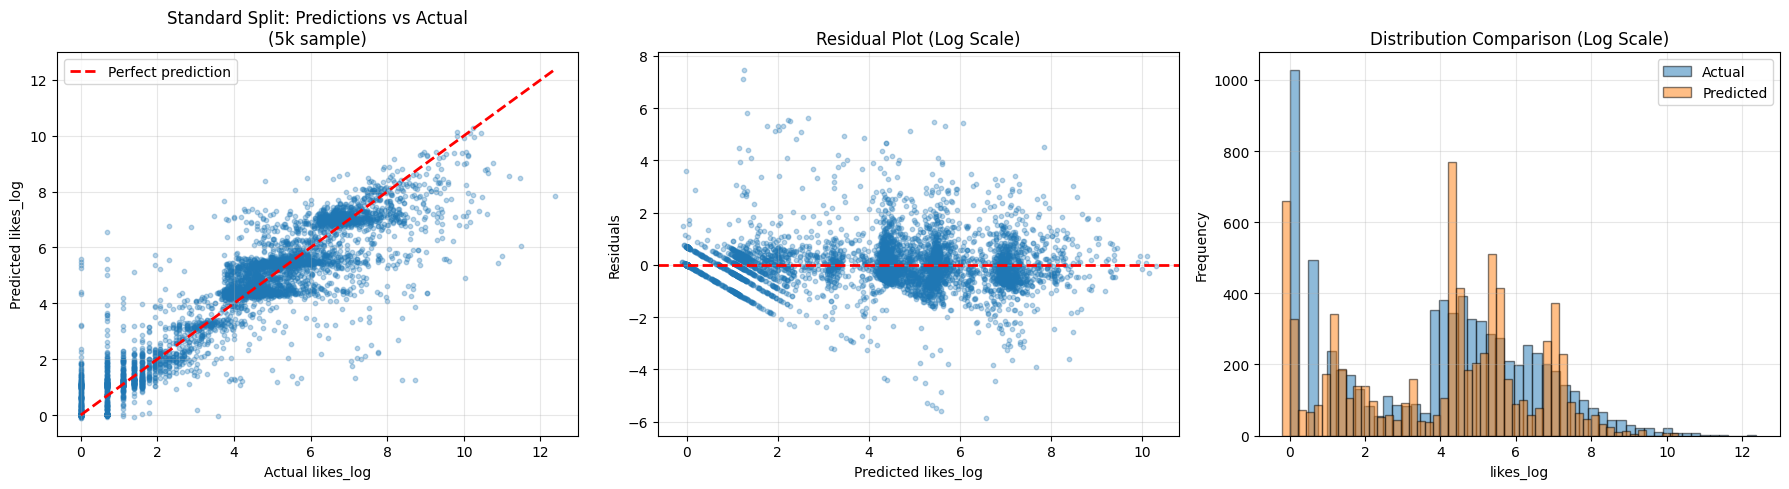


✓ Model saved to: /content/drive/MyDrive/AdobeBehaviourChal/saved_models/standard_split_model
  - classifier.pkl
  - regressor.pkl
  - metadata.json

TRAINING FOR UNSEEN BRANDS EVALUATION

✓ Created 5 bins:
  Bin 0: [0.00, 0.69)
  Bin 1: [0.69, 3.56)
  Bin 2: [3.56, 4.86)
  Bin 3: [4.86, 6.35)
  Bin 4: [6.35, 12.87)

TRAINING CLASSIFIER
✓ Classifier training accuracy: 0.9344

TRAINING REGRESSOR
✓ Regressor training RMSE: 0.3745
✓ Regressor training MAE:  0.2432

Unseen Brands Test Set PERFORMANCE
Metrics on Log Scale (likes_log):
  RMSE:  1.7136
  MAE:   1.3287
  R²:    0.0428

Metrics on Original Scale (likes):
  RMSE:  4156.5003
  MAE:   690.7120
  MAPE:  10566387372.72%


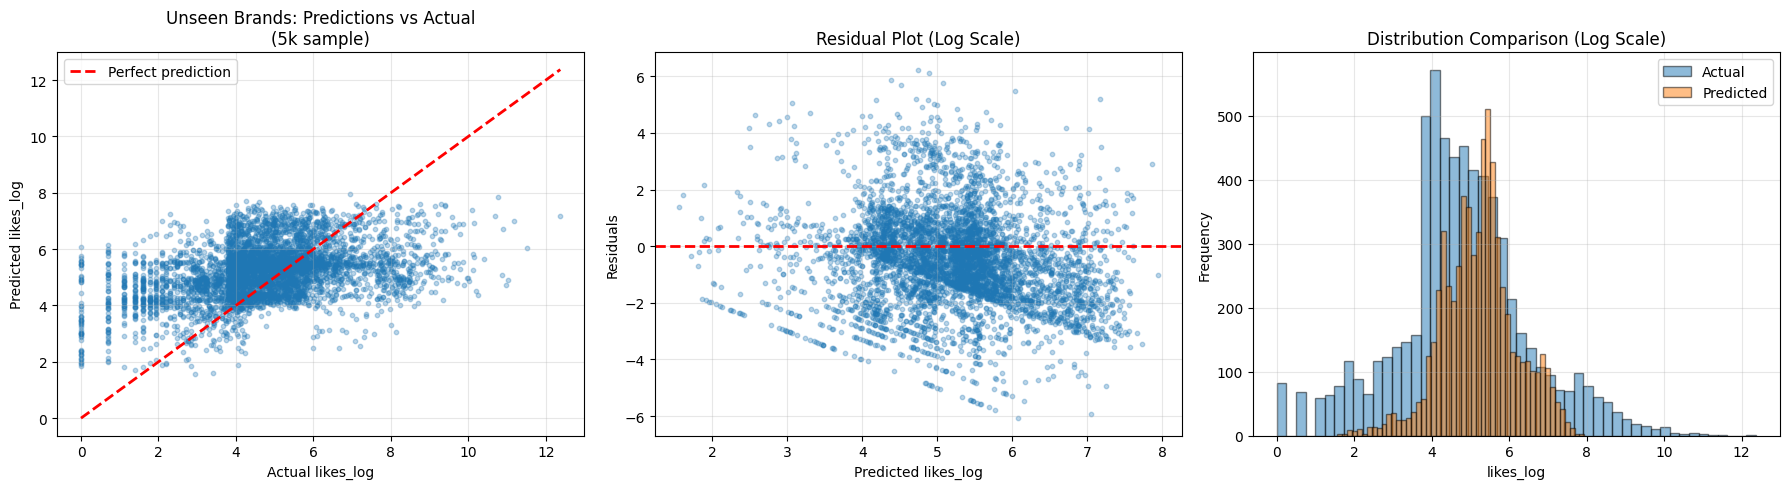


✓ Model saved to: /content/drive/MyDrive/AdobeBehaviourChal/saved_models/unseen_brands_model
  - classifier.pkl
  - regressor.pkl
  - metadata.json

FINAL SUMMARY

Standard Split Results:


KeyError: 'rmse'

In [ ]:
if __name__ == "__main__":
    # For Colab: Upload file or mount Google Drive
    # from google.colab import drive
    # drive.mount('/content/drive')
    # file_path = '/content/drive/MyDrive/processed_tweet_data.parquet'

    # For local execution:
    file_path = "/content/drive/MyDrive/AdobeBehaviourChal/Parquet/processed_tweet_data.parquet"

    # Run pipeline
    results = main_pipeline(
        file_path=file_path,
        n_bins=5,  # Try 3, 5, or 7
        test_on_unseen_brands=True,
        save_model=True,  # Set to False to skip saving
        model_name=None  # None = auto-generate with timestamp
    )

    print("\n✓ Training complete!")
    print("✓ Models saved and ready for predictions")

    # ============================================
    # EXAMPLE: Load and use saved model
    # ============================================
    print("\n" + "="*80)
    print("EXAMPLE: LOADING SAVED MODEL")
    print("="*80)

    # Load the standard model
    loaded_model = LGBMHybridModel.load_model('/content/drive/MyDrive/AdobeBehaviourChal/saved_models/standard_split_model')

    # Make predictions with loaded model
    # X_new = prepare_new_data(...)  # Your new data
    # predictions = loaded_model.predict(X_new)

    print("\n✓ Model loaded successfully and ready to use!")
    print("\nTo make predictions on new data:")
    print("  predictions = loaded_model.predict(X_new)")

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import json
from pathlib import Path
from datetime import datetime

class LGBMMultiRegressorModel:
    """
    Two-stage model:
    1. Classifier predicts engagement bin
    2. Separate Regressor for each bin
    """

    def __init__(self, bin_edges, verbose=True):
        self.bin_edges = np.array(bin_edges)
        self.n_bins = len(self.bin_edges) - 1
        self.verbose = verbose
        self.classifier = None
        self.regressors = {} # Dictionary to hold regressors for each bin

        if self.verbose:
            print(f"\n{'='*80}")
            print("INITIALIZING MULTI-REGRESSOR MODEL")
            print(f"{'='*80}")
            print(f"Using {self.n_bins} bins with edges:")
            for i in range(self.n_bins):
                print(f"  Bin {i}: [{self.bin_edges[i]:.2f}, {self.bin_edges[i+1]:.2f})")


    def _assign_bins(self, y):
        """Assign data to bins based on provided edges"""
        # Use right=False to make intervals [a, b)
        bins = np.digitize(y, self.bin_edges[1:-1], right=False)
        # Ensure values exactly at the upper edge of the last bin go into the last bin
        bins[y == self.bin_edges[-1]] = self.n_bins - 1
        return bins

    def fit(self, X, y, X_val=None, y_val=None):
        """Train the classifier and each regressor"""

        # Assign bins for training data
        y_bins = self._assign_bins(y)

        if self.verbose:
            print(f"\n{'='*80}")
            print("TRAINING CLASSIFIER")
            print(f"{'='*80}")

        # Train classifier to predict bins
        self.classifier = lgb.LGBMClassifier(
            objective='multiclass',
            num_class=self.n_bins,
            n_estimators=300,
            learning_rate=0.05,
            max_depth=8,
            num_leaves=31,
            feature_fraction=0.8,
            bagging_fraction=0.8,
            bagging_freq=5,
            min_child_samples=20,
            verbose=-1,
            device='gpu',  # Enable GPU training
            gpu_platform_id=0,
            gpu_device_id=0
        )

        if X_val is not None:
            y_val_bins = self._assign_bins(y_val)
            eval_set = [(X_val, y_val_bins)]
            callbacks = [lgb.early_stopping(50, verbose=False)]
        else:
            eval_set = None
            callbacks = None

        self.classifier.fit(X, y_bins, eval_set=eval_set, callbacks=callbacks)

        if self.verbose:
            train_acc = (self.classifier.predict(X) == y_bins).mean()
            print(f"✓ Classifier training accuracy: {train_acc:.4f}")
            if X_val is not None:
                val_acc = (self.classifier.predict(X_val) == y_val_bins).mean()
                print(f"✓ Classifier validation accuracy: {val_acc:.4f}")


        if self.verbose:
            print(f"\n{'='*80}")
            print("TRAINING REGRESSORS FOR EACH BIN")
            print(f"{'='*80}")

        # Train a separate regressor for each bin
        for bin_idx in range(self.n_bins):
            if self.verbose:
                print(f"\n  - Training Regressor for Bin {bin_idx}...")

            # Filter data for the current bin
            bin_mask = (y_bins == bin_idx)
            X_bin = X[bin_mask]
            y_bin = y[bin_mask]

            if len(X_bin) == 0:
                if self.verbose:
                    print(f"    ⚠️ No data points in Bin {bin_idx}. Skipping regressor training.")
                continue

            # Define and train regressor for this bin
            regressor = lgb.LGBMRegressor(
                objective='huber',
                alpha=0.9,
                n_estimators=500,
                learning_rate=0.03,
                max_depth=10,
                num_leaves=63,
                feature_fraction=0.8,
                bagging_fraction=0.8,
                bagging_freq=5,
                min_child_samples=20,
                verbose=-1,
                device='gpu',  # Enable GPU training
                gpu_platform_id=0,
                gpu_device_id=0
            )

            # Prepare validation set for this bin if available
            eval_set_bin = None
            callbacks_bin = None
            if X_val is not None:
                 # Predict validation bins using the trained classifier
                y_val_bins = self.classifier.predict(X_val) # Use predict for hard assignment
                val_bin_mask = (y_val_bins == bin_idx)
                X_val_bin = X_val[val_bin_mask]
                y_val_bin = y_val[val_bin_mask]
                if len(X_val_bin) > 0:
                    eval_set_bin = [(X_val_bin, y_val_bin)]
                    callbacks_bin = [lgb.early_stopping(100, verbose=False)]
                elif self.verbose:
                     print(f"    ⚠️ No validation data points assigned to Bin {bin_idx}.")


            regressor.fit(X_bin, y_bin, eval_set=eval_set_bin, callbacks=callbacks_bin)
            self.regressors[bin_idx] = regressor

            if self.verbose:
                y_pred_bin_train = regressor.predict(X_bin)
                rmse_bin_train = np.sqrt(mean_squared_error(y_bin, y_pred_bin_train))
                mae_bin_train = mean_absolute_error(y_bin, y_pred_bin_train)
                print(f"    ✓ Regressor Bin {bin_idx} training RMSE: {rmse_bin_train:.4f}")
                print(f"    ✓ Regressor Bin {bin_idx} training MAE:  {mae_bin_train:.4f}")


        return self

    def predict(self, X):
        """Predict likes_log using classifier and corresponding regressor"""
        if self.classifier is None or not self.regressors:
            raise RuntimeError("Model has not been trained yet. Call .fit() first.")

        # Predict bins using the classifier
        predicted_bins = self.classifier.predict(X)
        y_pred = np.zeros(len(X))

        # Use the appropriate regressor for each predicted bin
        for bin_idx in range(self.n_bins):
            bin_mask = (predicted_bins == bin_idx)
            if np.any(bin_mask):
                if bin_idx in self.regressors:
                    y_pred[bin_mask] = self.regressors[bin_idx].predict(X[bin_mask])
                else:
                     # Handle cases where a regressor wasn't trained for a bin (e.g., no data)
                     # Could use a default value, the bin center, or predict using a neighboring regressor
                     # For now, let's use the average prediction of available regressors or 0
                     if self.verbose:
                         print(f"    ⚠️ No regressor found for predicted Bin {bin_idx}. Using default prediction.")
                     # Simple fallback: use the mean of predictions from all available regressors
                     available_preds = []
                     for reg in self.regressors.values():
                         try:
                             available_preds.append(reg.predict(X[bin_mask]))
                         except:
                             pass # Handle potential errors if regressor can't predict on this subset
                     if available_preds:
                          y_pred[bin_mask] = np.mean(available_preds, axis=0)
                     else:
                          y_pred[bin_mask] = np.mean(self.bin_edges[bin_idx:bin_idx+2]) # Use bin center as fallback

        return y_pred

    def save_model(self, save_dir='/content/drive/MyDrive/AdobeBehaviourChal/saved_models', model_name=None):
        """
        Save model to disk

        Args:
            save_dir: Directory to save model
            model_name: Optional custom name, otherwise uses timestamp
        """
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

        if model_name is None:
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            model_name = f'multi_regressor_model_{timestamp}'

        model_path = save_dir / model_name
        model_path.mkdir(parents=True, exist_ok=True)

        # Save classifier
        with open(model_path / 'classifier.pkl', 'wb') as f:
            pickle.dump(self.classifier, f)

        # Save regressors
        regressors_dir = model_path / 'regressors'
        regressors_dir.mkdir(parents=True, exist_ok=True)
        for bin_idx, regressor in self.regressors.items():
            with open(regressors_dir / f'regressor_bin_{bin_idx}.pkl', 'wb') as f:
                pickle.dump(regressor, f)

        # Save metadata
        metadata = {
            'n_bins': self.n_bins,
            'bin_edges': self.bin_edges.tolist(),
            'saved_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        with open(model_path / 'metadata.json', 'w') as f:
            json.dump(metadata, f, indent=2)

        print(f"\n✓ Multi-Regressor Model saved to: {model_path}")
        print(f"  - classifier.pkl")
        print(f"  - regressors/ (contains individual regressor pickles)")
        print(f"  - metadata.json")

        return str(model_path)

    @classmethod
    def load_model(cls, model_path, verbose=True):
        """
        Load model from disk

        Args:
            model_path: Path to saved model directory
            verbose: Print loading info

        Returns:
            Loaded LGBMMultiRegressorModel instance
        """
        model_path = Path(model_path)

        if not model_path.exists():
            raise FileNotFoundError(f"Model path not found: {model_path}")

        # Load metadata
        with open(model_path / 'metadata.json', 'r') as f:
            metadata = json.load(f)

        # Create model instance
        model = cls(
            bin_edges=metadata['bin_edges'],
            verbose=verbose
        )

        # Load classifier
        with open(model_path / 'classifier.pkl', 'rb') as f:
            model.classifier = pickle.load(f)

        # Load regressors
        regressors_dir = model_path / 'regressors'
        if regressors_dir.exists():
            for regressor_file in regressors_dir.glob('regressor_bin_*.pkl'):
                try:
                    bin_idx = int(regressor_file.stem.split('_')[-1])
                    with open(regressor_file, 'rb') as f:
                        model.regressors[bin_idx] = pickle.load(f)
                except Exception as e:
                    if verbose:
                        print(f"    ⚠️ Error loading regressor file {regressor_file}: {e}")


        if verbose:
            print(f"\n✓ Multi-Regressor Model loaded from: {model_path}")
            print(f"  Saved at: {metadata['saved_at']}")
            print(f"  Bins: {model.n_bins}")
            print(f"  Loaded {len(model.regressors)} regressors.")


        return model

print("Multi-Regressor Model class defined")

Multi-Regressor Model class defined


## results

In [ ]:
# Define the bin edges based on the user's request
# These edges were derived from the output of the previous model's bin creation
multi_regressor_bin_edges = [0.00, 0.69, 3.56, 4.86, 6.35, 12.87]

# Load and prepare data using the existing function
# Using a smaller sample size for faster testing
file_path = "/content/drive/MyDrive/AdobeBehaviourChal/Parquet/processed_tweet_data.parquet" # Ensure this path is correct
X, y, metadata = load_and_prepare_data(file_path, max_rows=50000) # Use the same sample size as before

# Create evaluation splits using the existing function
splits = create_evaluation_splits(X, y, metadata)

# Instantiate the new Multi-Regressor Model with the defined bin edges
multi_regressor_model = LGBMMultiRegressorModel(bin_edges=multi_regressor_bin_edges, verbose=True)

print(f"\n{'='*80}")
print("STARTING MULTI-REGRESSOR MODEL TRAINING")
print(f"{'='*80}")

# Train the model
multi_regressor_model.fit(
    splits['standard']['X_train'],
    splits['standard']['y_train'],
    splits['standard']['X_val'],
    splits['standard']['y_val']
)

print("\n✓ Multi-Regressor Model training complete!")

Loading data...
⚠️ Loaded only 50,000 samples for testing (max_rows=50000)
✓ Applied PCA to user_company_embedding: reduced from 768 to 90 components
✓ Feature matrix shape: (50000, 865)
✓ Total features: 865 (6 time + 1 word_count + 768 content emb + 90 user_company_emb_pca)

CREATING EVALUATION SPLITS
Total samples: 50,000
Total companies: 214

✓ Standard Split:
  Train:  34,999 samples
  Val:     7,501 samples
  Test:    7,500 samples

✓ Unseen Brands Split:
  Train:  43,497 samples (182 companies)
  Test:    6,503 samples (32 companies)
  Test companies: ['allstate' 'ups' 'free' 'twitter' 'midea']... (showing first 5)

INITIALIZING MULTI-REGRESSOR MODEL
Using 5 bins with edges:
  Bin 0: [0.00, 0.69)
  Bin 1: [0.69, 3.56)
  Bin 2: [3.56, 4.86)
  Bin 3: [4.86, 6.35)
  Bin 4: [6.35, 12.87)

STARTING MULTI-REGRESSOR MODEL TRAINING

TRAINING CLASSIFIER
✓ Classifier training accuracy: 0.9561
✓ Classifier validation accuracy: 0.7327

TRAINING REGRESSORS FOR EACH BIN

  - Training Regresso


EVALUATING MULTI-REGRESSOR MODEL ON STANDARD TEST SET

Multi-Regressor Model - Standard Test Set PERFORMANCE
Metrics on Log Scale (likes_log):
  RMSE:  0.9684
  MAE:   0.5983
  R²:    0.8607

Metrics on Original Scale (likes):
  RMSE:  4077.8734
  MAE:   530.2456
  MAPE:  5137547348.33%


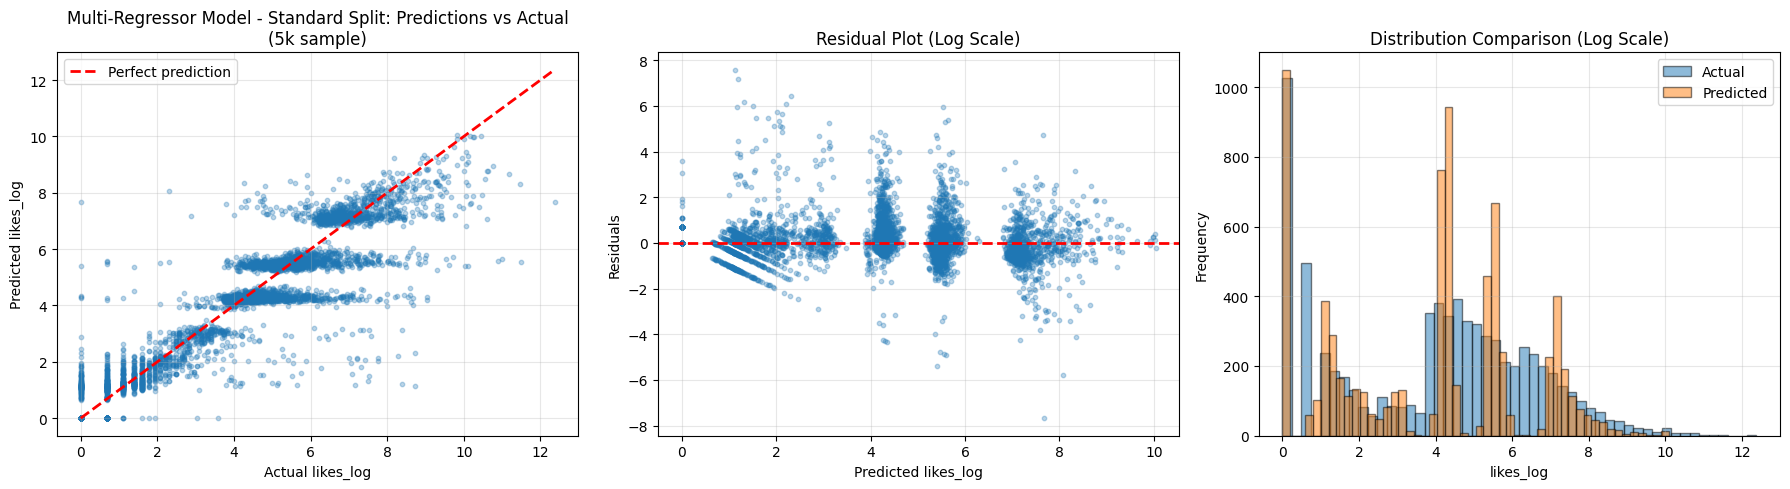


✓ Multi-Regressor Model evaluation complete!


In [ ]:
# Assuming multi_regressor_model has been trained in the previous cell
# and 'splits' dictionary is available from the data loading and splitting steps

print(f"\n{'='*80}")
print("EVALUATING MULTI-REGRESSOR MODEL ON STANDARD TEST SET")
print(f"{'='*80}")

# Get test data from the standard split
X_test_standard = splits['standard']['X_test']
y_test_standard = splits['standard']['y_test']

# Make predictions using the trained multi-regressor model
y_pred_standard = multi_regressor_model.predict(X_test_standard)

# Evaluate the model performance
results_multi_regressor_standard = evaluate_model(
    y_test_standard,
    y_pred_standard,
    "Multi-Regressor Model - Standard Test Set"
)

# Plot the predictions
plot_predictions(
    y_test_standard,
    y_pred_standard,
    "Multi-Regressor Model - Standard Split: Predictions vs Actual"
)

print("\n✓ Multi-Regressor Model evaluation complete!")


TRAINING MULTI-REGRESSOR MODEL FOR UNSEEN BRANDS EVALUATION

INITIALIZING MULTI-REGRESSOR MODEL
Using 5 bins with edges:
  Bin 0: [0.00, 0.69)
  Bin 1: [0.69, 3.56)
  Bin 2: [3.56, 4.86)
  Bin 3: [4.86, 6.35)
  Bin 4: [6.35, 12.87)

TRAINING CLASSIFIER
✓ Classifier training accuracy: 0.9359

TRAINING REGRESSORS FOR EACH BIN

  - Training Regressor for Bin 0...
    ✓ Regressor Bin 0 training RMSE: 0.0000
    ✓ Regressor Bin 0 training MAE:  0.0000

  - Training Regressor for Bin 1...
    ✓ Regressor Bin 1 training RMSE: 0.1267
    ✓ Regressor Bin 1 training MAE:  0.0935

  - Training Regressor for Bin 2...
    ✓ Regressor Bin 2 training RMSE: 0.0779
    ✓ Regressor Bin 2 training MAE:  0.0621

  - Training Regressor for Bin 3...
    ✓ Regressor Bin 3 training RMSE: 0.0900
    ✓ Regressor Bin 3 training MAE:  0.0717

  - Training Regressor for Bin 4...
    ✓ Regressor Bin 4 training RMSE: 0.2723
    ✓ Regressor Bin 4 training MAE:  0.1707

✓ Multi-Regressor Model training for unseen bra

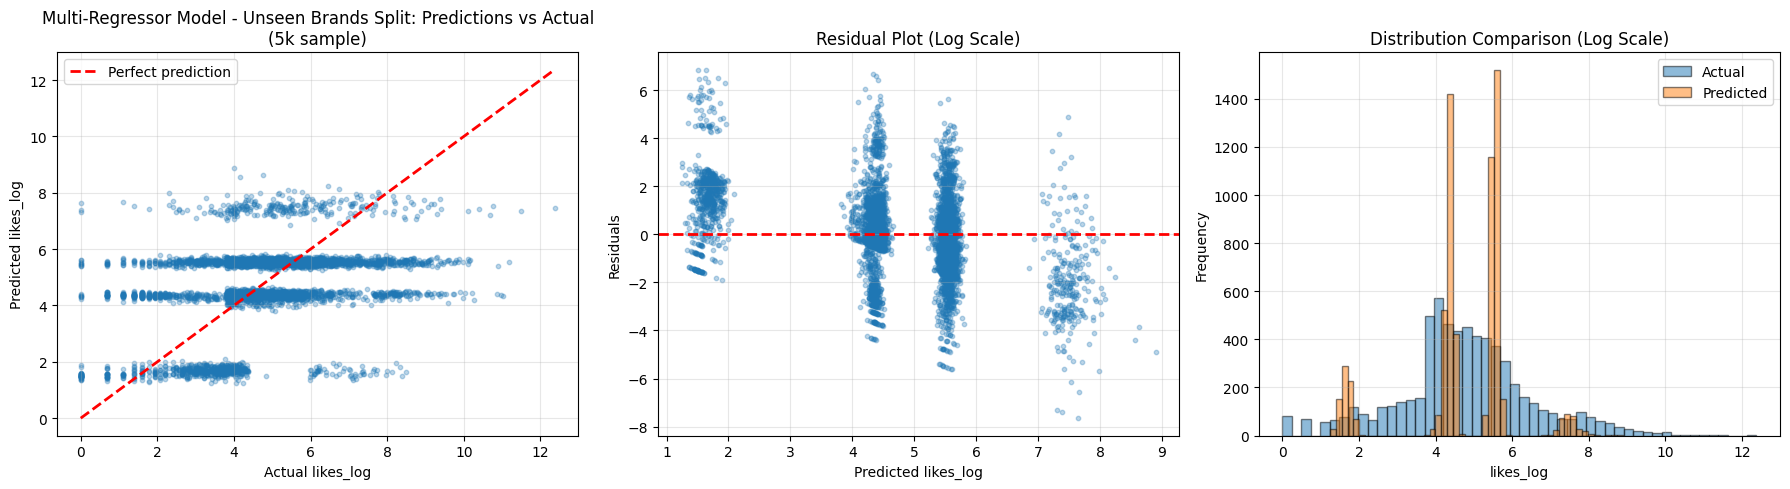


✓ Multi-Regressor Model unseen brands evaluation complete!


In [ ]:
# Assuming multi_regressor_model has been trained in the previous cell on the standard split
# and 'splits' dictionary is available from the data loading and splitting steps

print(f"\n{'='*80}")
print("TRAINING MULTI-REGRESSOR MODEL FOR UNSEEN BRANDS EVALUATION")
print(f"{'='*80}")

# Instantiate a new model for unseen brands training (or you could retrain the existing one)
# Using the same bin edges as before
multi_regressor_model_unseen = LGBMMultiRegressorModel(bin_edges=multi_regressor_bin_edges, verbose=True)

# Train the model on the unseen brands training data
multi_regressor_model_unseen.fit(
    splits['unseen_brands']['X_train'],
    splits['unseen_brands']['y_train']
)

print("\n✓ Multi-Regressor Model training for unseen brands complete!")

print(f"\n{'='*80}")
print("EVALUATING MULTI-REGRESSOR MODEL ON UNSEEN BRANDS TEST SET")
print(f"{'='*80}")

# Get test data from the unseen brands split
X_test_unseen = splits['unseen_brands']['X_test']
y_test_unseen = splits['unseen_brands']['y_test']

# Make predictions using the trained multi-regressor model (unseen brands)
y_pred_unseen = multi_regressor_model_unseen.predict(X_test_unseen)

# Evaluate the model performance
results_multi_regressor_unseen = evaluate_model(
    y_test_unseen,
    y_pred_unseen,
    "Multi-Regressor Model - Unseen Brands Test Set"
)

# Plot the predictions
plot_predictions(
    y_test_unseen,
    y_pred_unseen,
    "Multi-Regressor Model - Unseen Brands Split: Predictions vs Actual"
)

print("\n✓ Multi-Regressor Model unseen brands evaluation complete!")

In [ ]:
import numpy as np
# UNSEEN TIMES
bins_log_rmse = [0.0, 0.1075, 0.1837, 0.1104, 0.5195]
bins_log_mae  = [0.0, 0.0790, 0.1540, 0.0891, 0.3593]

# (min_log, max_log) for each bin
bins = [
    (0.00, 0.69),   # Very Low
    (0.69, 3.56),   # Low
    (3.56, 4.86),   # Medium
    (4.86, 6.35),   # High
    (6.35, 12.87)   # Very High
]

bin_counts = [6977, 13031, 10115, 9748, 10129]
bin_names = ["Very Low", "Low", "Medium", "High", "Very High"]

per_bin = []
weighted_mae_sum = 0
weighted_rmse_sum = 0
total = sum(bin_counts)

for i, (low, high) in enumerate(bins):
    mid_log = (low + high) / 2
    approx_likes = np.exp(mid_log) - 1

    mae_likes = (np.exp(bins_log_mae[i]) - 1) * (approx_likes + 1)
    rmse_likes = (np.exp(bins_log_rmse[i]) - 1) * (approx_likes + 1)

    per_bin.append({
        "Bin": bin_names[i],
        "Min Likes": round(np.exp(low)-1, 2),
        "Max Likes": round(np.exp(high)-1, 2),
        "Avg Likes": round(approx_likes, 2),
        "MAE Likes": round(mae_likes, 2),
        "RMSE Likes": round(rmse_likes, 2),
        "Count": bin_counts[i]
    })

    weighted_mae_sum += mae_likes * bin_counts[i]
    weighted_rmse_sum += rmse_likes * bin_counts[i]

# Print per-bin info with newline formatting
for bin_data in per_bin:
    print(f"\n{bin_data['Bin']} Bin:")
    print(f"  Min Likes = {bin_data['Min Likes']}, Max Likes = {bin_data['Max Likes']}, "
          f"Avg Likes = {bin_data['Avg Likes']}, Count = {bin_data['Count']}")
    print(f"  RMSE = {bin_data['RMSE Likes']}, MAE = {bin_data['MAE Likes']}\n")

global_mae_likes = weighted_mae_sum / total
global_rmse_likes = weighted_rmse_sum / total

print("Weighted Global MAE (likes):", round(global_mae_likes, 2))
print("Weighted Global RMSE (likes):", round(global_rmse_likes, 2))



Very Low Bin:
  Min Likes = 0.0, Max Likes = 0.99, Avg Likes = 0.41, Count = 6977
  RMSE = 0.0, MAE = 0.0


Low Bin:
  Min Likes = 0.99, Max Likes = 34.16, Avg Likes = 7.37, Count = 13031
  RMSE = 0.95, MAE = 0.69


Medium Bin:
  Min Likes = 34.16, Max Likes = 128.02, Avg Likes = 66.36, Count = 10115
  RMSE = 13.58, MAE = 11.21


High Bin:
  Min Likes = 128.02, Max Likes = 571.49, Avg Likes = 270.78, Count = 9748
  RMSE = 31.72, MAE = 25.33


Very High Bin:
  Min Likes = 571.49, Max Likes = 388480.18, Avg Likes = 14912.17, Count = 10129
  RMSE = 10158.66, MAE = 6447.36

Weighted Global MAE (likes): 1313.49
Weighted Global RMSE (likes): 2067.12


In [ ]:
import numpy as np
# UNSEEN BRANDS
bins_log_rmse = [0.0, 0.1267, 0.0779, 0.0900, 0.2723]
bins_log_mae  = [0.0, 0.0935, 0.0621, 0.0717, 0.1707]

# (min_log, max_log) for each bin
bins = [
    (0.00, 0.69),   # Very Low
    (0.69, 3.56),   # Low
    (3.56, 4.86),   # Medium
    (4.86, 6.35),   # High
    (6.35, 12.87)   # Very High
]

bin_counts = [6977, 13031, 10115, 9748, 10129]
bin_names = ["Very Low", "Low", "Medium", "High", "Very High"]

per_bin = []
weighted_mae_sum = 0
weighted_rmse_sum = 0
total = sum(bin_counts)

for i, (low, high) in enumerate(bins):
    mid_log = (low + high) / 2
    approx_likes = np.exp(mid_log) - 1

    mae_likes = (np.exp(bins_log_mae[i]) - 1) * (approx_likes + 1)
    rmse_likes = (np.exp(bins_log_rmse[i]) - 1) * (approx_likes + 1)

    per_bin.append({
        "Bin": bin_names[i],
        "Min Likes": round(np.exp(low)-1, 2),
        "Max Likes": round(np.exp(high)-1, 2),
        "Avg Likes": round(approx_likes, 2),
        "MAE Likes": round(mae_likes, 2),
        "RMSE Likes": round(rmse_likes, 2),
        "Count": bin_counts[i]
    })

    weighted_mae_sum += mae_likes * bin_counts[i]
    weighted_rmse_sum += rmse_likes * bin_counts[i]

# Print per-bin info with newline formatting
for bin_data in per_bin:
    print(f"\n{bin_data['Bin']} Bin:")
    print(f"  Min Likes = {bin_data['Min Likes']}, Max Likes = {bin_data['Max Likes']}, "
          f"Avg Likes = {bin_data['Avg Likes']}, Count = {bin_data['Count']}")
    print(f"  RMSE = {bin_data['RMSE Likes']}, MAE = {bin_data['MAE Likes']}\n")

global_mae_likes = weighted_mae_sum / total
global_rmse_likes = weighted_rmse_sum / total

print("Weighted Global MAE (likes):", round(global_mae_likes, 2))
print("Weighted Global RMSE (likes):", round(global_rmse_likes, 2))



Very Low Bin:
  Min Likes = 0.0, Max Likes = 0.99, Avg Likes = 0.41, Count = 6977
  RMSE = 0.0, MAE = 0.0


Low Bin:
  Min Likes = 0.99, Max Likes = 34.16, Avg Likes = 7.37, Count = 13031
  RMSE = 1.13, MAE = 0.82


Medium Bin:
  Min Likes = 34.16, Max Likes = 128.02, Avg Likes = 66.36, Count = 10115
  RMSE = 5.46, MAE = 4.32


High Bin:
  Min Likes = 128.02, Max Likes = 571.49, Avg Likes = 270.78, Count = 9748
  RMSE = 25.59, MAE = 20.2


Very High Bin:
  Min Likes = 571.49, Max Likes = 388480.18, Avg Likes = 14912.17, Count = 10129
  RMSE = 4667.54, MAE = 2775.86

Weighted Global MAE (likes): 567.36
Weighted Global RMSE (likes): 951.94
